# Stack Overflow Trends
## By: Karthik Sankar
This Jupyter Notebook will attempt to find the factors that effect the odds of your question being answered successfully. <br>
Success is defined as a question having a high scoring answer, having many answers and having a small answer wait time

In [1]:
#Basic set up for Google BigQuery

# Install the package with: pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper
#!pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

#I've created an API key for this project and included it in the project folder.
#I would never store an API key in this way for a real project, it is only included this way for this demo
#https://cloud.google.com/docs/authentication/getting-started
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="Stack Overflow Project.json"
#!set GOOGLE_APPLICATION_CREDENTIALS="C:\Users\karth\Documents\MLprojects\Stack Overflow\Stack Overflow Project.json"

In [2]:
#Import the stackoverflow dataset from Google BigQuery

import bq_helper
import numpy as np
from bq_helper import BigQueryHelper
import pandas as pd
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="stackoverflow")

stackOverflow.list_tables()

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [3]:
#Filter the useful datapoints from BigQuery and save them locally
#Questions are from 2018 so they had enough time to get answered
query_get_answers = """ Select questions.title as question_title, questions.body as question_body, questions.answer_count as question_answer_count,users_question.reputation as question_users_reputation, questions.creation_date as question_date,
answers.creation_date as answer_date, answers.score as answer_score,
questions.score as question_score,questions.tags

from `bigquery-public-data.stackoverflow.posts_questions` as questions
JOIN 
`bigquery-public-data.stackoverflow.posts_answers` as answers
on questions.id = answers.parent_id
JOIN
`bigquery-public-data.stackoverflow.users` as users_answer
on answers.owner_user_id = users_answer.id
JOIN 
`bigquery-public-data.stackoverflow.users` as users_question
on questions.owner_user_id = users_question.id
where answers.owner_user_id Is NOT NULL and questions.owner_user_id is not NULL and questions.tags is NOT NULL 
and Extract(Year from questions.creation_date)>2017 and Extract(Year from questions.creation_date)<2019

limit 10000
;

"""

stack_overflow_data = stackOverflow.query_to_pandas_safe(query_get_answers,30)
stack_overflow_data.to_csv('stack_overflow_question_data_10000.csv', index=False)
len(stack_overflow_data)

10000

In [4]:
stack_overflow_data.head()

,question_title,question_body,question_answer_count,question_users_reputation,question_date,answer_date,answer_score,question_score,tags
0,Cannot find module '@babel/core',<p>I am following along with this webpack4/rea...,6,397,2018-08-29 00:40:27.630000+00:00,2018-08-29 00:46:40.600000+00:00,76,30,node.js|reactjs|npm|webpack|babeljs
1,How to install JDK 11 under Ubuntu?,"<p>So Java 11 <a href=""https://mail.openjdk.ja...",6,5426,2018-09-25 18:42:16.510000+00:00,2018-09-26 01:57:31.687000+00:00,1,42,java|ubuntu|java-11
2,Parse multilevel JSON in JS,<p>I've got JSON like this:</p>\n\n<pre><code>...,3,1,2018-09-23 12:01:48.690000+00:00,2018-09-23 12:29:07.363000+00:00,2,-5,javascript|json
3,Can Java 10 type inference for local variables...,"<p>With Java 10, we can use type inference.</p...",1,706,2018-03-22 12:45:09.043000+00:00,2018-03-22 12:57:39.230000+00:00,32,19,java|type-inference|java-10
4,Is log4j2 compatible with Java 11?,<p>I tried to run my project on the latest Jav...,4,5426,2018-10-29 15:57:15.093000+00:00,2019-05-01 18:27:00.947000+00:00,0,15,java|log4j2|java-11


In [5]:
stack_overflow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
question_title               10000 non-null object
question_body                10000 non-null object
question_answer_count        10000 non-null int64
question_users_reputation    10000 non-null int64
question_date                10000 non-null datetime64[ns, UTC]
answer_date                  10000 non-null datetime64[ns, UTC]
answer_score                 10000 non-null int64
question_score               10000 non-null int64
tags                         10000 non-null object
dtypes: datetime64[ns, UTC](2), int64(4), object(3)
memory usage: 703.2+ KB


## Cleaning and converting the dataset
Question Title and Question Body may play a role in the success of a question<br>
At this time, the title is a string and the body is in XML.<br>
The following code will clean the XML and run sentiment anaysis on both data sets<br>

In [6]:
#Run sentiment analysis on every question title and body (values range from -1.0 to 1.0)

#!pip install textblob
from textblob import TextBlob
import re
def getPolarity(txt):
    #print(txt)
    return TextBlob(txt).sentiment.polarity

TAG_RE = re.compile(r'<[^>]+>')
def cleanText(txt): #gets rid of HTML tags
    #print(txt)
    return TAG_RE.sub('\n', txt)

stack_overflow_data["question_title_polarity"] = stack_overflow_data.apply(lambda row: getPolarity(row["question_title"]), axis=1)
stack_overflow_data["question_body_polarity"] = stack_overflow_data.apply(lambda row: getPolarity(cleanText(row["question_body"])), axis=1)

Question Date and Answer Date are datetime objects<br>
The following code will convert them into unix time and subtract the two to get the time elapsed<br>
It will scale down the time elapsed to reduce it's weighting later on in the notebook<br>
Finally, smaller wait times are better so the times are remapped to e^-x of their current value so that the smallest times result in the largest values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BEA8201748>]],
      dtype=object)

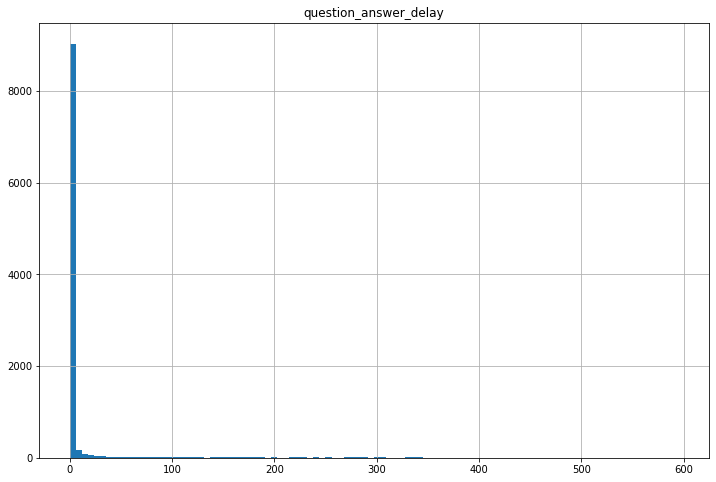

In [45]:
# question_date and answer_date are both datetime objects. This will combine them into a usable integer metric
stack_overflow_data["question_answer_delay"] = (stack_overflow_data["answer_date"]-stack_overflow_data["question_date"]) / np.timedelta64(1, 'h') / 24
stack_overflow_data.hist(column="question_answer_delay", figsize=(12,8), bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BEA2E30208>]],
      dtype=object)

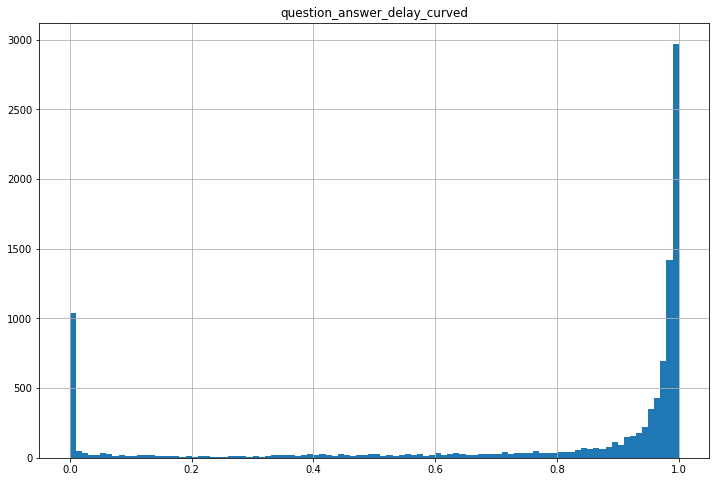

In [8]:
from math import e
def curve(num):
    #print(num)
    return e**(-num)
stack_overflow_data["question_answer_delay_curved"] = stack_overflow_data.apply(lambda row: curve(row["question_answer_delay"]), axis=1)
stack_overflow_data.hist(column="question_answer_delay_curved", figsize=(12,8), bins=100)

In [9]:
def countTags(txt):
    if txt.strip()=="":
        return 0
    return txt.count("|")+1
stack_overflow_data["tags_count"] = stack_overflow_data.apply(lambda row: countTags(row["tags"]), axis=1)

Several variables will be combined to create a "question success" metric

In [10]:
#Create a new attribute that measures how successful a question was
stack_overflow_data["question_success"] = stack_overflow_data["answer_score"]*stack_overflow_data["question_answer_count"]*stack_overflow_data["question_answer_delay_curved"]

In [11]:
stack_overflow_data.describe()

,question_answer_count,question_users_reputation,answer_score,question_score,question_title_polarity,question_body_polarity,question_answer_delay,question_answer_delay_curved,tags_count,question_success
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,1.914400,2888.031800,1.087300,0.836000,0.004947,0.030725,13.297314,7.826118e-01,2.920400,1.742876
std,1.170047,16927.624822,2.411651,3.323764,0.146798,0.175766,59.065980,3.434714e-01,1.213924,7.018096
min,1.000000,1.000000,-5.000000,-10.000000,-0.800000,-1.000000,0.000355,4.924234e-259,1.000000,-9.971783
25%,1.000000,27.000000,0.000000,0.000000,0.000000,-0.035606,0.008305,7.505293e-01,2.000000,0.000000
50%,2.000000,115.000000,1.000000,0.000000,0.000000,0.028788,0.029213,9.712098e-01,3.000000,0.002328
75%,2.000000,748.250000,1.000000,1.000000,0.000000,0.125000,0.286977,9.917291e-01,4.000000,1.981422
max,12.000000,235072.000000,82.000000,101.000000,1.000000,1.000000,594.775370,9.996455e-01,5.000000,454.035790


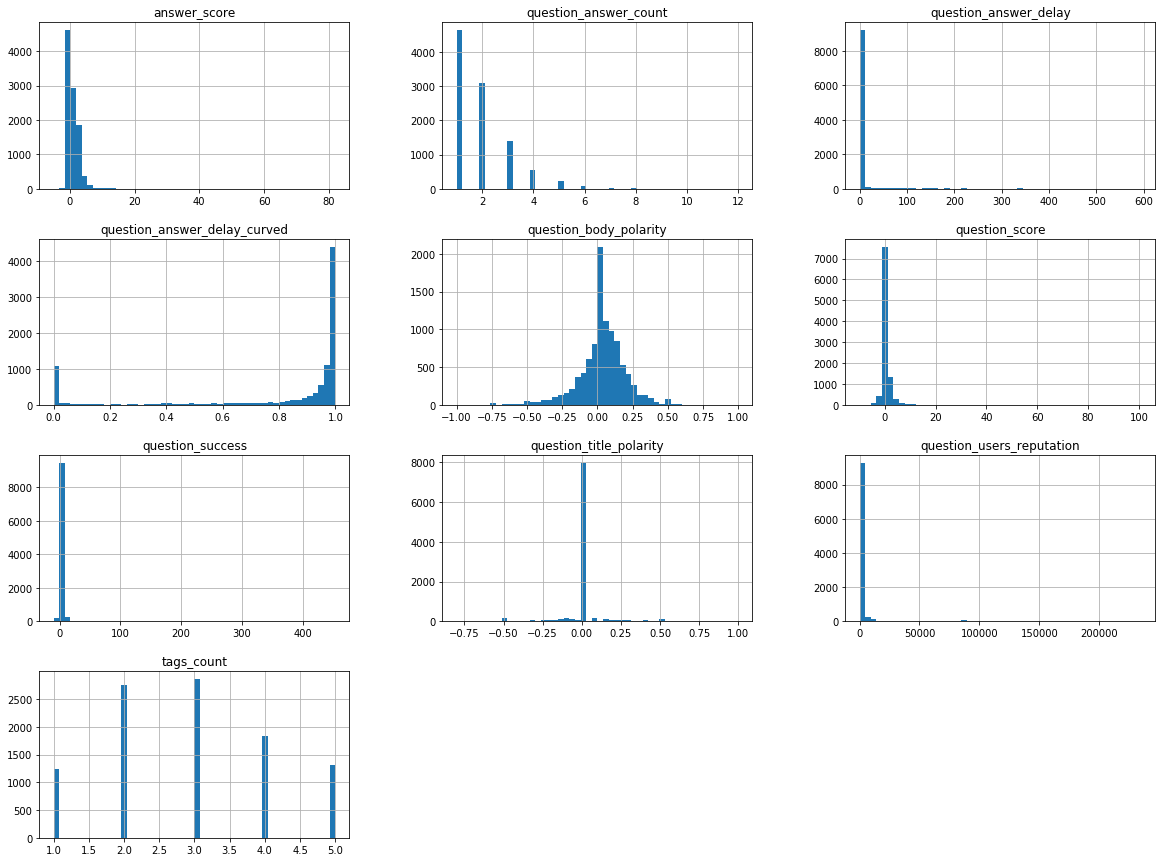

In [12]:
#A histogram of every numerical column in stack_overflow_data
#!pip install matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
stack_overflow_data.hist(bins=50, figsize=(20,15))
plt.show()

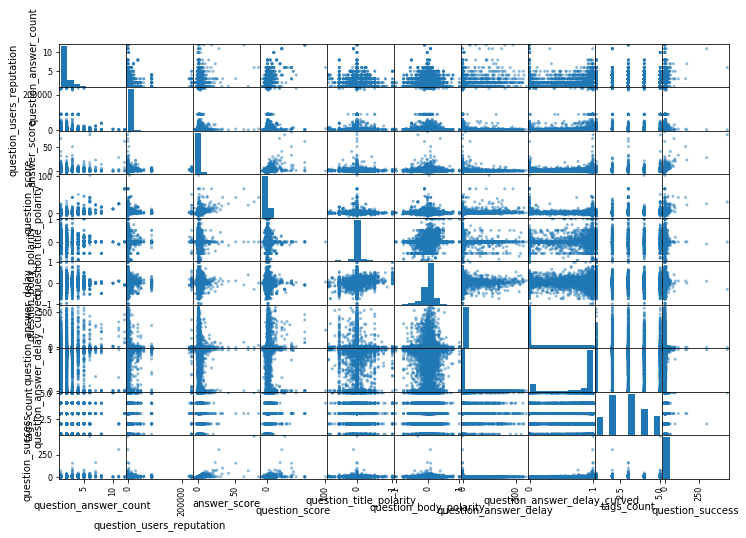

In [13]:
from pandas.plotting import scatter_matrix
scatter_matrix(stack_overflow_data, figsize=(12, 8)); #[attributes]

This grid serves as a starting point<br>
Below we will go in depth on the correlated variables

In [14]:
#stack_overflow_data.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

c:\users\karth\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


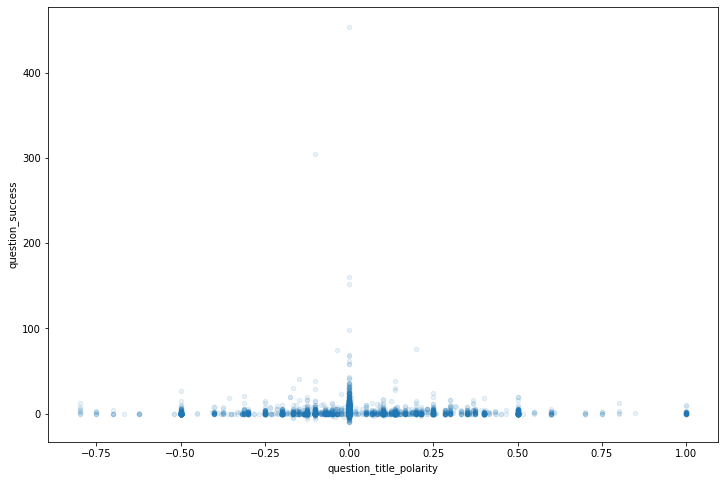

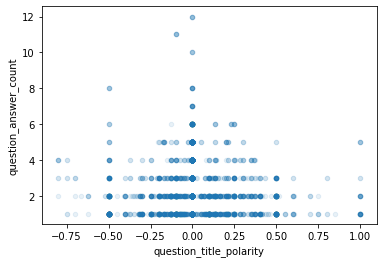

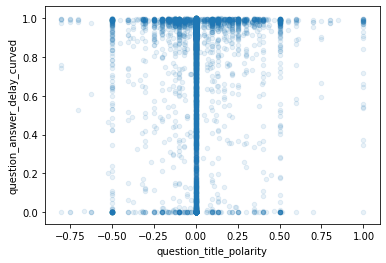

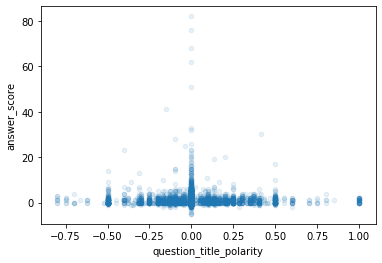

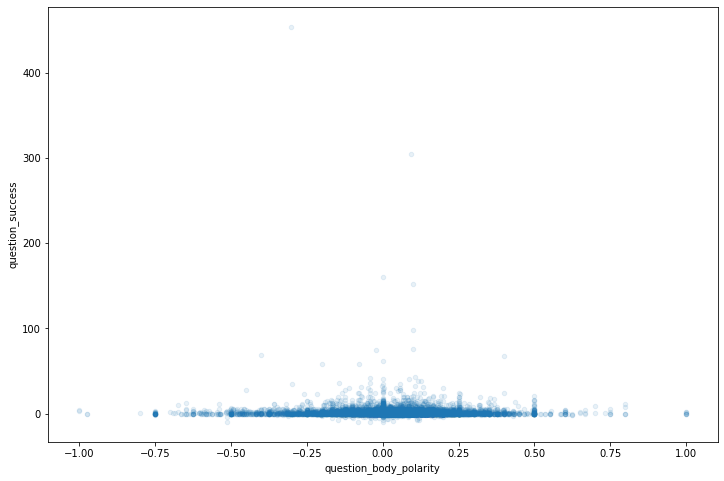

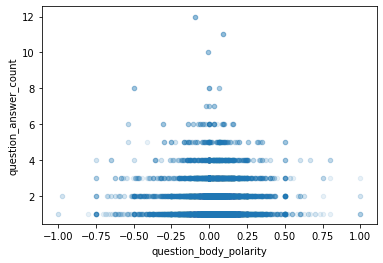

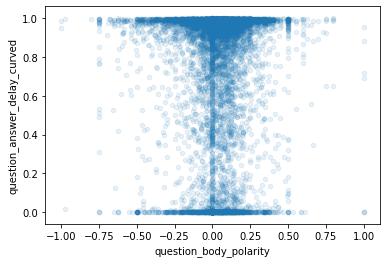

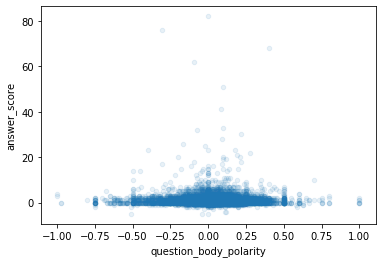

In [15]:
#Gragh new polarity values
stack_overflow_data.plot(kind="scatter", x="question_title_polarity", y="question_success", alpha=0.1, figsize=(12,8))
stack_overflow_data.plot(kind="scatter", x="question_title_polarity", y="question_answer_count", alpha=0.1)
stack_overflow_data.plot(kind="scatter", x="question_title_polarity", y="question_answer_delay_curved", alpha=0.1)
stack_overflow_data.plot(kind="scatter", x="question_title_polarity", y="answer_score", alpha=0.1)

stack_overflow_data.plot(kind="scatter", x="question_body_polarity", y="question_success", alpha=0.1, figsize=(12,8))
stack_overflow_data.plot(kind="scatter", x="question_body_polarity", y="question_answer_count", alpha=0.1)
stack_overflow_data.plot(kind="scatter", x="question_body_polarity", y="question_answer_delay_curved", alpha=0.1)
stack_overflow_data.plot(kind="scatter", x="question_body_polarity", y="answer_score", alpha=0.1)

There are some very large outliers for the answer scores. A ceiling will help reduce the dead space. 

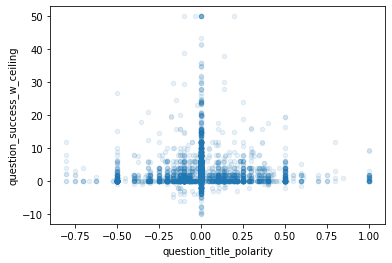

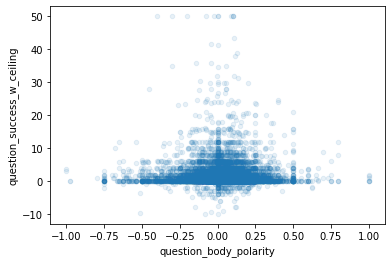

In [16]:
#Adding a ceiling so a few high values don't skew the results
stack_overflow_data["answer_score_w_ceiling"] = stack_overflow_data["answer_score"].clip(upper=25)
stack_overflow_data["question_answer_count_w_ceiling"] = stack_overflow_data["question_answer_count"].clip(upper=8)


stack_overflow_data["question_success_w_ceiling"] = stack_overflow_data["answer_score_w_ceiling"]*stack_overflow_data["question_answer_count_w_ceiling"]*stack_overflow_data["question_answer_delay_curved"]
stack_overflow_data["question_success_w_ceiling"] = stack_overflow_data["question_success_w_ceiling"].clip(upper=50)

#Gragh polarity against new success column with ceiling
stack_overflow_data.plot(kind="scatter", x="question_title_polarity", y="question_success_w_ceiling", alpha=.1)
stack_overflow_data.plot(kind="scatter", x="question_body_polarity", y="question_success_w_ceiling", alpha=.1)

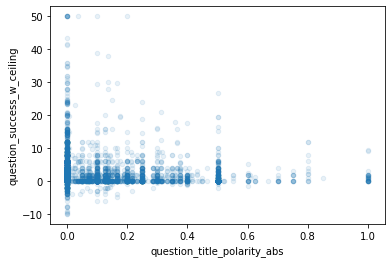

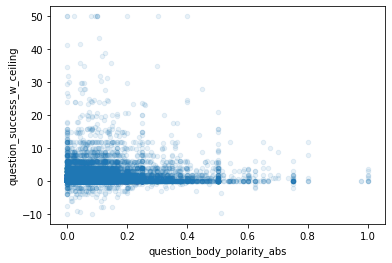

In [17]:
#taking the absolute value of polarity to represent how neutral a statement is
stack_overflow_data["question_title_polarity_abs"] = abs(stack_overflow_data["question_title_polarity"])
stack_overflow_data["question_body_polarity_abs"] = abs(stack_overflow_data["question_body_polarity"])

stack_overflow_data.plot(kind="scatter", x="question_title_polarity_abs", y="question_success_w_ceiling", alpha=.1)
stack_overflow_data.plot(kind="scatter", x="question_body_polarity_abs", y="question_success_w_ceiling", alpha=.1)

The triangle shape suggests that the more emotionally nueral the title and body of a question are, the higher the quality of responses you will receive.

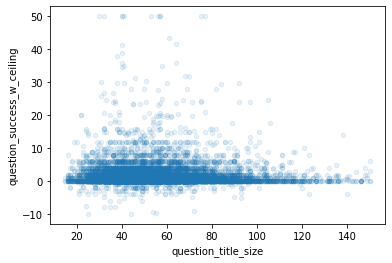

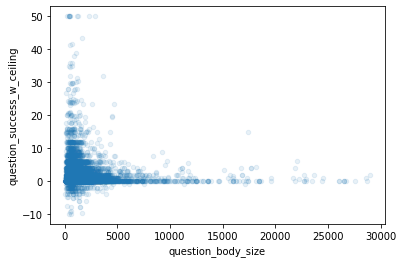

In [18]:
stack_overflow_data["question_title_size"] = stack_overflow_data.apply(lambda row: len(row["question_title"]), axis=1)
stack_overflow_data["question_body_size"] = stack_overflow_data.apply(lambda row: len(row["question_body"]), axis=1)
stack_overflow_data.plot(kind="scatter", x="question_title_size", y="question_success_w_ceiling", alpha=0.1)
stack_overflow_data.plot(kind="scatter", x="question_body_size", y="question_success_w_ceiling", alpha=0.1)

##### Question titles between 30 and 65 characters  seem to do the best
##### Question bodies under 2000 characters  have the best success rate

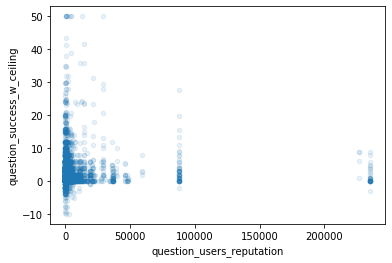

In [19]:
stack_overflow_data.plot(kind="scatter", x="question_users_reputation", y="question_success_w_ceiling", alpha=0.1)

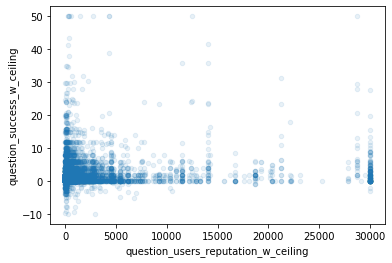

In [20]:
#Add a ceiling to the reputation
stack_overflow_data["question_users_reputation_w_ceiling"] = stack_overflow_data["question_users_reputation"].clip(upper=30000)
stack_overflow_data.plot(kind="scatter", x="question_users_reputation_w_ceiling", y="question_success_w_ceiling", alpha=0.1)

Low reputation users have very high success rates and very low success rates <br>
It may look like a lower reputation has the highest success rate but this is simply due to the fact that most users have a low repuation so there is more variation.<br>
It is also worth noting that low reputation users also have some of the worst success rates

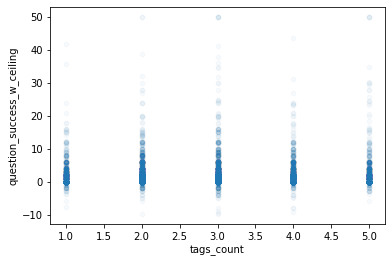

In [21]:
stack_overflow_data.plot(kind="scatter", x="tags_count", y="question_success_w_ceiling", alpha=.03)

Number of tags has almost nothing to do with question success

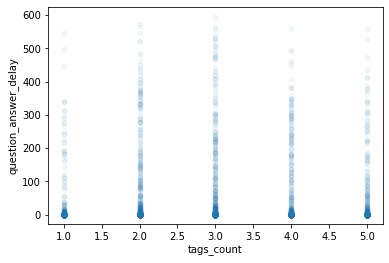

In [22]:
stack_overflow_data.plot(kind="scatter", x="tags_count", y="question_answer_delay", alpha=.05)

1 or 5 tags is the ideal ammount of tags to get a speedy response<br>
This is likely due to 1 tag questions being spefic and easy to answer and 5 tag questions being easy to find. The tags inbetween are likely specialized questions that involve multiple topics which make them slow to answer<br><br>

## ML Model to predict question - answer wait time

In [23]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(stack_overflow_data, test_size=0.2, random_state=42)

In [24]:
corr_matrix = stack_overflow_data.corr()
corr_matrix["question_answer_delay"].sort_values(ascending=False)

question_answer_delay                  1.000000
question_score                         0.204262
question_answer_count                  0.105890
question_answer_count_w_ceiling        0.097301
question_title_size                    0.050306
tags_count                             0.026501
question_title_polarity_abs            0.024138
question_body_size                     0.021796
question_users_reputation_w_ceiling    0.009402
question_users_reputation              0.006087
question_body_polarity_abs             0.004476
question_body_polarity                -0.015066
answer_score                          -0.033548
answer_score_w_ceiling                -0.043714
question_title_polarity               -0.053942
question_success                      -0.055661
question_success_w_ceiling            -0.099985
question_answer_delay_curved          -0.509671
Name: question_answer_delay, dtype: float64

question_score, question_answer_count and question_title_size have the strongest correlation with time to answer

In [25]:
stack_overflow_data_inputs = train_set
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_answer_count_w_ceiling", axis=1) # duplicate
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_users_reputation", axis=1) # duplicate
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_body_polarity", axis=1) # duplicate
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_title_polarity_abs", axis=1) # duplicate 
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("answer_score", axis=1) # duplicate

#getting rid of bad predictors
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_users_reputation_w_ceiling", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("tags_count", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_body_size", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("answer_score_w_ceiling", axis=1)


#getting rid of anything calculated from answer_delay
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_success", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_success_w_ceiling", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_answer_delay_curved", axis=1)

#getting rid of non - numerical datapoints
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_title", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_body", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_date", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("answer_date", axis=1)
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("tags", axis=1)

stack_overflow_data_outputs = train_set["question_answer_delay"].copy()
stack_overflow_data_inputs = stack_overflow_data_inputs.drop("question_answer_delay", axis=1)


stack_overflow_data_inputs

,question_answer_count,question_score,question_title_polarity,question_body_polarity_abs,question_title_size
9254,3,-2,0.000,0.155519,40
1561,2,0,0.000,0.000000,27
1670,2,0,0.500,0.166667,42
6087,3,1,0.000,0.056061,34
6669,1,1,-0.500,0.000000,76
...,...,...,...,...,...
5734,1,1,-0.125,0.043019,68
5191,1,1,0.000,0.454167,75
5390,1,1,0.000,0.068056,16
860,2,0,0.000,0.098639,66


### Using LinearRegression

In [26]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(stack_overflow_data_inputs, stack_overflow_data_outputs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, stack_overflow_data_inputs, stack_overflow_data_outputs, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print("Scores:", rmse_scores)
print("Mean:", rmse_scores.mean())
print("Standard deviation:", rmse_scores.std())

Scores: [66.41804821 62.55032235 64.46234881 50.83486595 55.52896754 50.4811019
 58.31556925 51.35871311 49.95752033 63.33553591]
Mean: 57.32429933546011
Standard deviation: 6.165224096114444


### Using DecisionTreeRegressor

In [28]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(stack_overflow_data_inputs, stack_overflow_data_outputs)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [29]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, stack_overflow_data_inputs, stack_overflow_data_outputs, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print("Scores:", rmse_scores)
print("Mean:", rmse_scores.mean())
print("Standard deviation:", rmse_scores.std())

Scores: [89.09072828 79.24864366 86.39308301 72.85905631 68.45879279 65.96485509
 65.6695533  76.21558416 67.30329546 80.49644976]
Mean: 75.17000418275924
Standard deviation: 8.081478200750386


### Using RandomForestRegressor

In [30]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(stack_overflow_data_inputs, stack_overflow_data_outputs)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [31]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, stack_overflow_data_inputs, stack_overflow_data_outputs, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print("Scores:", rmse_scores)
print("Mean:", rmse_scores.mean())
print("Standard deviation:", rmse_scores.std())

Scores: [68.6104523  66.49845762 68.4400285  58.31460887 57.93457035 54.78182784
 60.51029075 56.71130471 54.11291866 69.76300671]
Mean: 61.56774663089482
Standard deviation: 5.817314071683219


## The RandomForestRegressor has the lowest root mean square error so it will be the choosen model
Fine tuning the model with a grid search

In [32]:
#Test various hyper parameters and compare them with each other
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [1, 3, 10, 15, 20, 25, 30, 35], 'max_features': [1,2,3,4]},
    {'bootstrap': [False], 'n_estimators': [1, 3, 10, 20, 30, 35], 'max_features': [1,2,3,4]},  
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(stack_overflow_data_inputs, stack_overflow_data_outputs)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [33]:
#Print the results of all the other tested hyperparameters
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

78.53571950662753 {'max_features': 1, 'n_estimators': 1}
66.15404413987517 {'max_features': 1, 'n_estimators': 3}
62.483480506692935 {'max_features': 1, 'n_estimators': 10}
61.77366294936817 {'max_features': 1, 'n_estimators': 15}
61.6187287218602 {'max_features': 1, 'n_estimators': 20}
61.38863815197241 {'max_features': 1, 'n_estimators': 25}
61.189752420984654 {'max_features': 1, 'n_estimators': 30}
61.215113322937725 {'max_features': 1, 'n_estimators': 35}
77.82239113713247 {'max_features': 2, 'n_estimators': 1}
65.92285981224026 {'max_features': 2, 'n_estimators': 3}
63.25952049621223 {'max_features': 2, 'n_estimators': 10}
62.05940258814306 {'max_features': 2, 'n_estimators': 15}
61.850919159894254 {'max_features': 2, 'n_estimators': 20}
62.120902938787495 {'max_features': 2, 'n_estimators': 25}
61.73884659189309 {'max_features': 2, 'n_estimators': 30}
61.36330992669208 {'max_features': 2, 'n_estimators': 35}
76.98058432530559 {'max_features': 3, 'n_estimators': 1}
67.450324947592

In [34]:
#Get hyperparameters that result in the lowest error
grid_search.best_params_

{'max_features': 1, 'n_estimators': 30}

In [35]:
#Create the model best on the best hyper parameters
final_model = grid_search.best_estimator_

## Testing the final model with the test set

This set has not been shown to any model until now

In [36]:
#Clean test set in the same way as training set

stack_overflow_data_inputs_test = test_set
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_answer_count_w_ceiling", axis=1) # duplicate
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_users_reputation", axis=1) # duplicate
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_body_polarity", axis=1) # duplicate
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_title_polarity_abs", axis=1) # duplicate 
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("answer_score", axis=1) # duplicate

#getting rid of bad predictors
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_users_reputation_w_ceiling", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("tags_count", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_body_size", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("answer_score_w_ceiling", axis=1)

#getting rid of anything calculated from answer_delay
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_success", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_success_w_ceiling", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_answer_delay_curved", axis=1)

#getting rid of non - numerical datapoints
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_title", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_body", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_date", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("answer_date", axis=1)
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("tags", axis=1)

stack_overflow_data_outputs_test = test_set["question_answer_delay"].copy()
stack_overflow_data_inputs_test = stack_overflow_data_inputs_test.drop("question_answer_delay", axis=1)


stack_overflow_data_inputs_test

,question_answer_count,question_score,question_title_polarity,question_body_polarity_abs,question_title_size
6252,1,1,1.000000,0.275000,51
4684,1,0,0.000000,0.193782,110
1731,2,0,0.400000,0.333333,77
4742,2,0,0.000000,0.000000,63
4521,3,0,0.000000,0.022222,27
...,...,...,...,...,...
6412,1,1,-0.095833,0.016667,109
8285,2,3,-0.400000,0.007143,39
7853,1,2,0.000000,0.114583,36
1095,3,0,0.250000,0.229167,28


In [37]:
#Find the error with the final model
from sklearn.metrics import mean_squared_error

final_predictions = final_model.predict(stack_overflow_data_inputs_test)
final_mse = mean_squared_error(stack_overflow_data_outputs_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse 

63.18319279081203

In [38]:
#Function that takes advantage of model to make predictions
def predictDaysTillBestAnswer(numberOfExistingAnswers,currentQuestionScore,title,body):
    return final_model.predict(np.array([[numberOfExistingAnswers,currentQuestionScore,getPolarity(title),len(title),abs(getPolarity(cleanText(body)))]]))[0]

# Here is a prediction function that uses the model trained above
## It returns the expected number of days between the question being asked and the answer being chosen
### Parameters: Number of existing answers, current question score, title, body

In [44]:
predictDaysTillBestAnswer(0,0,"Help pls I'm confused","<p>How do I copy and paste stuff?</p><br><p>I've been trying for hours and I just can't figure it out. Can someone from this beautiful online community please help me.</p><small>Thanks,<br>Karthik Sankar</small>")

5.653550039429015

In [43]:
predictDaysTillBestAnswer(1,-5,"Addition Help","<p>I need to add 12345 and 54321. <br>If anyone could help, that would be much appreciated.</p>")

2.1326550122170773